In [10]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Generate 20 samples from a normal dist and then plot histogram

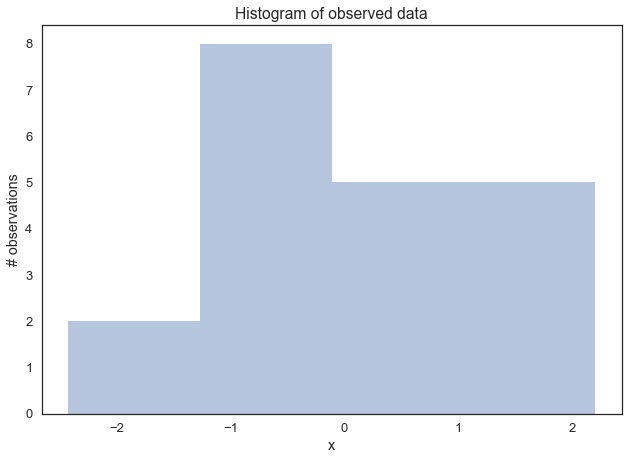

In [11]:
data = np.random.randn(20)
# Plotting
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

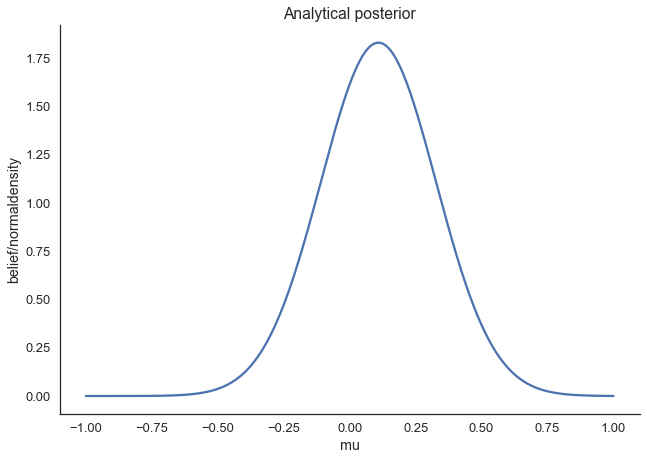

In [12]:
def calc_posterior_analytical(data,x, mu_0,sigma_0):
    '''Takes the prior mean and variance put on the parameter \mu, parameter \sigma = 1 is fixed
    As the prior on the mean and the assumed form of the likelihood are normal, as the 
    likelihood and prior on the mean are conjugate, it means that the posterior will
    have normal form that is P(\mu| x)~ N(x;\mu, \sigma = 1)N(\mu;\mu_0,\sigma_0) '''
    
    sigma         = 1
    var_post_num  = sigma**2 * sigma_0**2
    var_post_den  = len(data)*sigma_0**2 + sigma**2
    var_post      = var_post_num / var_post_den
    
    mean_data      = sum(data) / len(data)
    mean_post_num  = len(data)*sigma_0**2 * mean_data
    mean_post_den  = len(data)*sigma_0**2 + sigma**2
    mean_post      = mean_post_num/mean_post_den
    
    return norm(mean_post, np.sqrt(var_post)).pdf(x)

ax = plt.subplot()
x  = np.linspace(-1,1,500)
posterior_analytical = calc_posterior_analytical(data,x,0.,1.)
ax.plot(x,posterior_analytical)
ax.set(xlabel = 'mu',ylabel = 'belief/normaldensity', title = 'Analytical posterior')
sns.despine()

Typically our likelihood and prior parameters do not have conjugate distributions and so MCMC methods are needed. When using something like MH our intial starting parameter position $\mu_{current}$ = np.randn(0,1). 

In [14]:
mu_current = 1

Then we propose a jump distance $\gamma$ , which moves from the current location to a new location "The Markov part" . The$\gamma$ can either be cleaverly constructed or just sampled from a probability distribution which is centred around the  $\mu_{current}$ and a certain $\sigma_{current}$ " The proposal width", that determines how far we jump. 


```python
proposal = norm(mu_current,proposal_width).rvs()
#This returns a “frozen” RV object holding the given parameters fixed
```


Next we evaluate whether it is a good place to jump to or not "The Acceptance". I.e if the $\mu_{current} = \mu_{new}$ explains the data better than $\mu_{previous}$, then we want to go there. **But what does better mean?** 

This is quantified by computing the probability of the data | the likelihood with the propsed mean $\mu_{new}$ and fixed $\sigma = 1$ (in this case). Which is calculated by taking the product of the individual probabilities: 

```python 
likihood_current = norm(mu_current, 1).pdf(data).prod()
likihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
```

The prior probabilities for the current and proposed $\mu$ are given as:


```python
prior_current   = norm(mu_prior_mu, mu_prior_std).pdf(mu_current)
prior_proposal  = norm(mu_prior_mu, mu_prior_std).pdf(mu_proposal)
```

Then via Bayes, the numerator is:
```python
    post_current     = likihood_current * prior_current
    post_proposal    = likihood_proposal * prior_proposal
```

Therefore our probability of **acceptance** is given as:
```python
p_accept  = post_proposal/ post_current
```


```python
accept = np.random.rand() < p_accept
if accept:
    # update position
    current_pos = proposal
    ```

In [25]:
def sampler(data, samples = 4, mu_init = 0.5, proposal_width = 0.5, plot = False, mu_prior_mu = 0, mu_prior_sd =1):
    mu_current = mu_init
    posterior  = [mu_current]
    
    for i in range(samples):
        # suggest new positon
        mu_proposal = norm(mu_current,proposal_width).rvs()
        
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        post_current = likelihood_current * prior_current
        post_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = post_proposal / post_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    # creates four subplots with subplot options
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current  = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior          = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current  = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

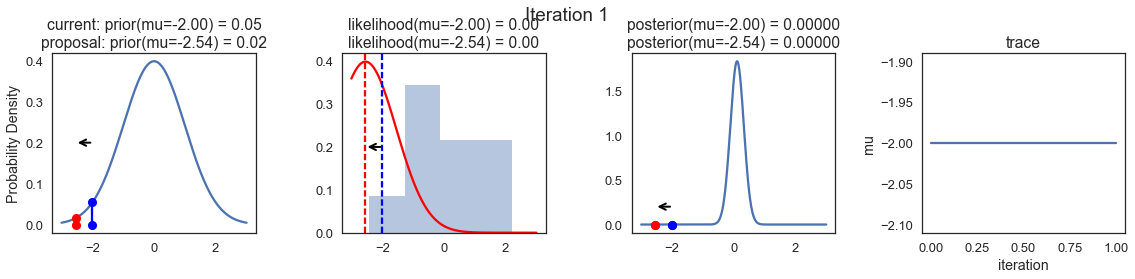

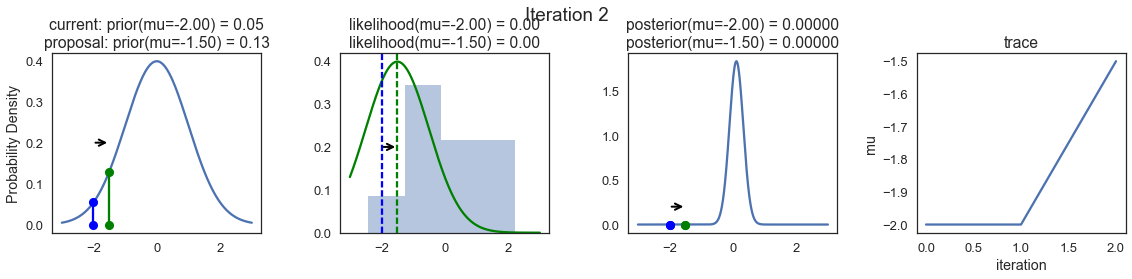

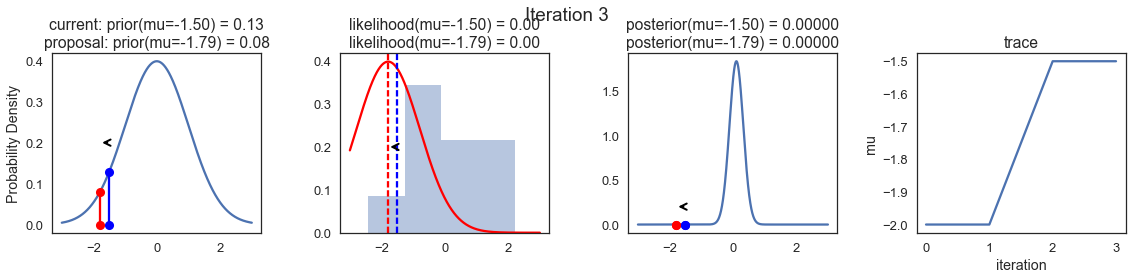

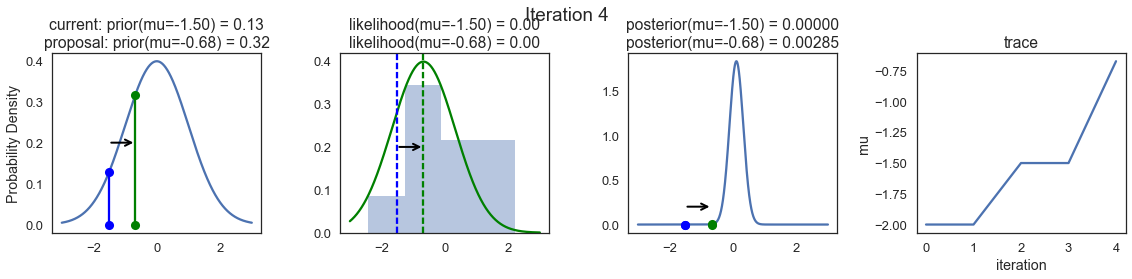

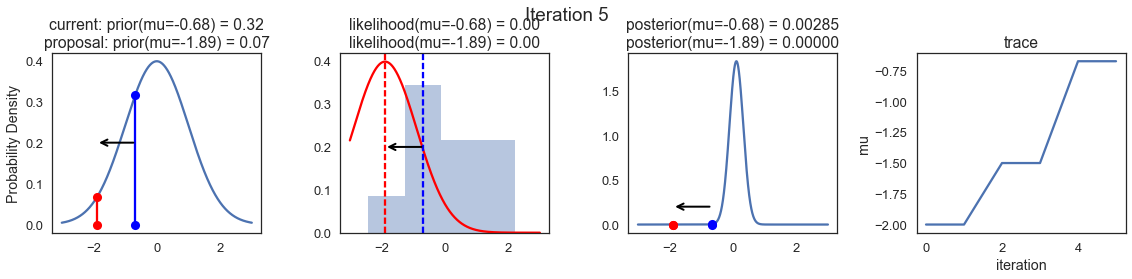

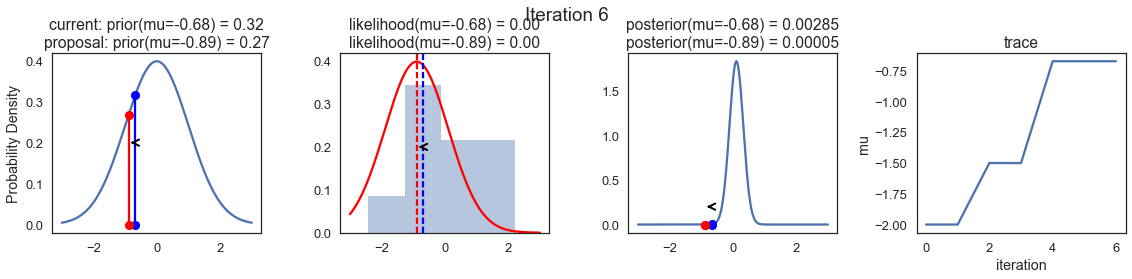

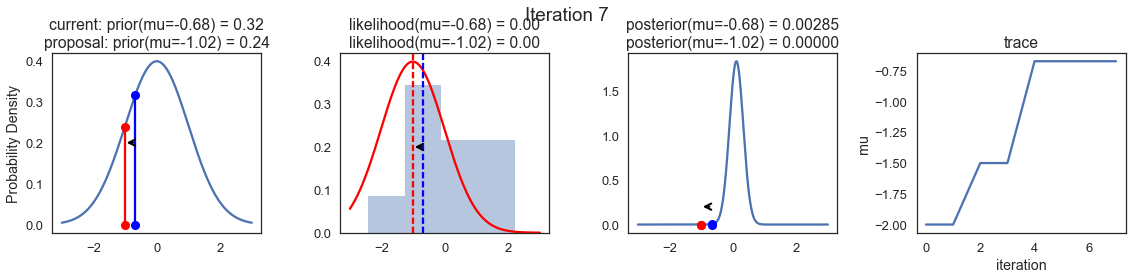

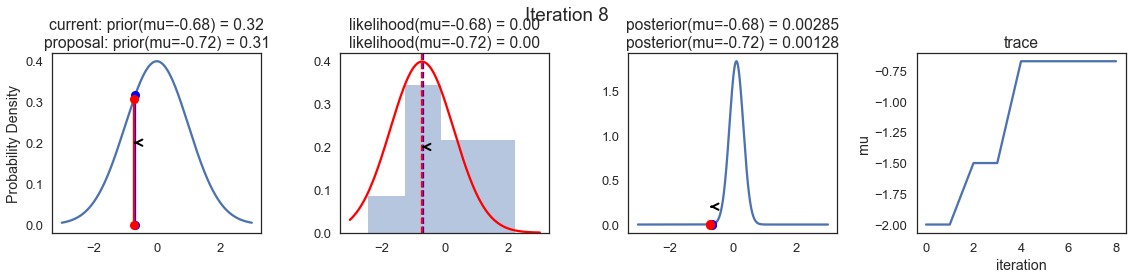

In [28]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1, plot=True);